In [1]:
import sys


sys.path.append("../src/")

In [2]:
from sennet.custom_modules.metrics.surface_dice_metric_fast import create_table_neighbour_code_to_surface_area
from sennet.custom_modules.losses.custom_losses import SurfaceDiceLoss, DiceLoss
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
device = "cuda"

## Dummy Data Stuffs

In [4]:
def build_sphere_data(cube_size: int, center_zyx: np.ndarray, radius: int):
    # arr = np.zeros((cube_size, cube_size, cube_size))
    zs, ys, xs = np.meshgrid(
        np.arange(cube_size),
        np.arange(cube_size),
        np.arange(cube_size),
        indexing="ij",
    )
    arr = (
        (zs-center_zyx[0])**2
        + (ys-center_zyx[1])**2
        + (xs-center_zyx[2])**2
    ) ** 0.5
    label = arr < radius
    return arr, label


def build_cylinder_data(cube_size: int, center_zyx: np.ndarray, radius: int):
    # arr = np.zeros((cube_size, cube_size, cube_size))
    zs, ys, xs = np.meshgrid(
        np.arange(cube_size),
        np.arange(cube_size),
        np.arange(cube_size),
        indexing="ij",
    )
    arr = (
        (ys-center_zyx[1])**2
        + (xs-center_zyx[2])**2
    ) ** 0.5
    label = arr < radius
    return arr, label

## Optimizing a tensor into a label

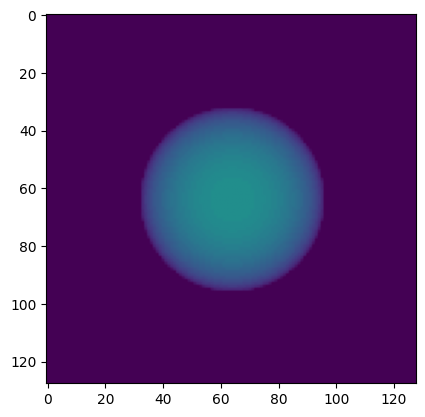

In [5]:
cube_size = 128
center = np.full(3, cube_size/2)
# center = np.random.uniform(0, cube_size, 3)
radius = cube_size / 4
_, label = build_sphere_data(cube_size, center, radius)

# label[:] = 1
# label[:] = 0

plt.imshow(label.mean(0), vmin=0, vmax=1)

In [6]:
label_tensor = torch.from_numpy(label).unsqueeze(0).to(device).float()

# pred_tensor = torch.rand((1, cube_size, cube_size, cube_size)).to(device)
pred_tensor = torch.full((1, cube_size, cube_size, cube_size), 0.99999).to(device)
# pred_tensor = torch.full((1, cube_size, cube_size, cube_size), 0.5).to(device)
# pred_tensor = torch.full((1, cube_size, cube_size, cube_size), 0.0001).to(device)
raw_pred_tensor = torch.log(pred_tensor / (1 - pred_tensor + 1e-8))
raw_pred_tensor = raw_pred_tensor.requires_grad_(True)

# pred_tensor = torch.ones((1, cube_size, cube_size, cube_size)).to(device) * 1.0
# pred_tensor = pred_tensor.requires_grad_(True)

# criterion = nn.BCEWithLogitsLoss()
# criterion = DiceLoss()
criterion = SurfaceDiceLoss(smooth=1e-6, device=device, verbose=False)

optim = torch.optim.AdamW([raw_pred_tensor], lr=1e-1)
# optim = torch.optim.AdamW([pred_tensor], lr=1e-1)

# print(f"{torch.sigmoid(raw_pred_tensor).min()}, {torch.sigmoid(raw_pred_tensor).max()}")
print(f"{label_tensor.shape=}")
print(f"{criterion=}")

label_tensor.shape=torch.Size([1, 128, 128, 128])
criterion=SurfaceDiceLoss(
  (unfold): Unfold(kernel_size=(2, 2), dilation=1, padding=1, stride=1)
)


In [ ]:
from sennet.core.submission_utils import evaluate_chunked_inference_in_memory
from tqdm.notebook import tqdm


dices = []
losses = []
for i in tqdm(range(2000)):
    optim.zero_grad()
    loss = criterion(raw_pred_tensor, label_tensor)
    # loss = criterion.forward_sigmoid(pred_tensor, label_tensor)
    loss.backward()
    optim.step()
    if i % 50 == 0:
        with torch.no_grad():
            metrics = evaluate_chunked_inference_in_memory(
                mean_prob_chunk=torch.sigmoid(raw_pred_tensor[0]).cpu().numpy(),
                # mean_prob_chunk=pred_tensor[0].cpu().numpy(),
                label=label_tensor[0].cpu().numpy().astype(bool),
                thresholds=[0.5],
                device="cuda",
                disable_tqdm=True,
            )
            surface_dice = metrics.surface_dices[0]

            dices.append(surface_dice)
            losses.append(loss.cpu().item())

            print(f"[{i=}]: loss={loss.cpu().item()}, {surface_dice=}")
            if surface_dice > 0.99:
                print("converged!")
                break

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(dices, color="orange", label="dice")
ax1.set_ylabel("dices")
ax2 = ax1.twinx()
ax2.plot(losses, color="blue", label="loss")
ax2.set_ylabel("loss")
fig.tight_layout()
fig.legend()
plt.title(str(criterion))
file_name = f"c{cube_size}_{criterion.__class__.__name__}.png"
plt.savefig(f"/home/clay/research/kaggle/sennet/data_dumps/surface_dice_exp/{file_name}")

In [ ]:
pred = torch.sigmoid(raw_pred_tensor)[0].cpu().detach()

print(pred[0, 0, 0])
print(pred.max())
print(pred.min())

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


pred = torch.sigmoid(raw_pred_tensor)[0].cpu().detach()
# pred = pred_tensor[0].cpu().detach()


fig = plt.figure()
im = plt.imshow(
    pred[0].cpu().numpy(), 
    interpolation='none',
    vmin=0,
    vmax=1,
)


def init():
    im.set_data(pred[0].cpu().numpy())
    return [im]

def animate(i):
    im.set_data(pred[i].cpu().numpy())
    return [im]

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(pred), interval=50)

from IPython.display import HTML
HTML(ani.to_jshtml())

## All in training a model

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
class SphereDataset(torch.utils.data.Dataset):
    def __init__(self, cube_size: int, radius: int, length: int = 1000):
        self.cube_size = cube_size
        self.radius = radius
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        center_zyx = np.random.uniform(0, self.cube_size, 3)
        img, seg = build_sphere_data(self.cube_size, center_zyx, self.radius)
        # img, seg = build_cylinder_data(self.cube_size, center_zyx, self.radius)
        img = torch.from_numpy(img).float().unsqueeze(0)
        seg = torch.from_numpy(seg).float().unsqueeze(0)
        return {
            "img": img,
            "seg": seg,
        }

In [ ]:
cube_size = 32
radius = cube_size / 4
d = SphereDataset(cube_size, radius)
item = d[25]
plt.imshow(item["img"].sum(1).cpu().numpy()[0])
plt.figure()
plt.imshow(item["seg"].sum(1).cpu().numpy()[0])

In [ ]:
from sennet.custom_modules.models.wrapped_models import WrappedUNet3D, SMPModel
from sennet.core.submission_utils import evaluate_chunked_inference_in_memory
import timm

In [ ]:
import pytorch_lightning as pl


class ThreeDSegTask(pl.LightningModule):
    def __init__(self, model, criterion, val_dataloader, input_key: str = "img"):
        pl.LightningModule.__init__(self)
        self.model = model
        self.criterion = criterion
        self.val_dataloader = val_dataloader
        self.input_key = input_key

    def training_step(self, batch: dict, batch_idx: int):
        self.model = self.model.train()

        seg_pred = self.model.predict(batch[self.input_key])
        preds = seg_pred.pred
        gt_seg_map = batch["seg"].float()

        _, pred_d, pred_h, pred_w = preds.shape
        _, _, gt_d, gt_h, gt_w = gt_seg_map.shape
        if (gt_d != pred_d) or (gt_h != pred_h) or (gt_w != pred_w):
            raise RuntimeError(":D")
        else:
            resized_pred = preds

        loss = self.criterion(resized_pred, gt_seg_map[:, 0, ...])
        self.log_dict({"train_loss": loss,}, prog_bar=True)
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        return

    def on_validation_epoch_end(self) -> None:
        with torch.no_grad():
            self.model = self.model.eval()

            metrics = None
            val_loss = None
            for batch in self.val_dataloader:
                pred = self.model.predict(batch[self.input_key].to(self.device))
                gt_seg_map = batch["seg"].float().to(self.device)

                metrics = evaluate_chunked_inference_in_memory(
                    mean_prob_chunk=torch.sigmoid(pred.pred[0]).cpu().numpy(),
                    label=gt_seg_map[0, 0, ...].cpu().numpy().astype(bool),
                    thresholds=[0.5],
                    device="cuda",
                )
                val_loss = self.criterion(pred.pred, gt_seg_map[:, 0, ...])

                break  # only eval one cube

            print("--------------------------------")
            print(f"{metrics = }")
            print(f"{val_loss = }")
            print("--------------------------------")
            self.log_dict({
                "val_loss": val_loss,
                "val_surface_dice": metrics.surface_dices[0],
                "val_f1": metrics.f1_scores[0],
            })


    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3, eps=1e-8)
        # return torch.optim.AdamW(self.model.parameters(), lr=1e-1, eps=1e-8)

In [ ]:
cube_size = 32
radius = cube_size / 4


train_dataset = SphereDataset(cube_size, radius, length=500)
val_dataset = SphereDataset(cube_size, radius, length=1)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)
model = SMPModel(
    "Unet",
    encoder_name="resnet34",
    encoder_weights="imagenet",
    replace_batch_norm_with_layer_norm=False,
    in_channels=cube_size,
    classes=cube_size,
).to(device).train()

In [ ]:
from pytorch_lightning.loggers import WandbLogger

In [ ]:
class CombinedLoss(nn.Module):
    def __init__(self, losses):
        nn.Module.__init__(self)
        self.losses = losses

    def forward(self, pred, target):
        return sum(loss(pred, target) for loss in self.losses) / len(self.losses)

In [ ]:
# criterion = nn.BCEWithLogitsLoss()
# criterion = DiceLoss()
criterion = SurfaceDiceLoss(device=device)
# criterion = CombinedLoss([nn.BCEWithLogitsLoss(), SurfaceDiceLoss(device=device)])
# criterion = CombinedLoss([DiceLoss(), SurfaceDiceLoss(device=device)])

input_key = "img"
# input_key = "seg"

task = ThreeDSegTask(model, criterion, val_loader, input_key)

In [ ]:
trainer = pl.Trainer(
    accelerator="gpu",
    # logger=WandbLogger(project="sphere"),
    max_epochs=10,
    # precision="16",
    benchmark=True,
    devices=-1,
)
trainer.fit(
    model=task,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

In [ ]:
trained_model = task.model.eval().to(device)

thresholds = np.arange(0, 1.1, 0.1)
metrics = None
with torch.no_grad():
    val_item = val_dataset[0]
    val_img = val_item[input_key].to(device)
    val_label = val_item["seg"][0].cpu()
    model_out = trained_model.predict(val_img.unsqueeze(0).to(device))

    raw_pred = model_out.pred[0].cpu()
    pred = torch.sigmoid(raw_pred).cpu()

#     metrics = evaluate_chunked_inference_in_memory(
#         mean_prob_chunk=pred.numpy(),
#         label=val_label.numpy().astype(bool),
#         thresholds=thresholds,
#         device="cuda",
#     )

# print(f"{metrics = }")


# plt.plot(thresholds, metrics.surface_dices)
# plt.figure()
plt.imshow(pred.mean(0).cpu().numpy(), vmin=0, vmax=1)
plt.figure()
plt.imshow(val_label.mean(0).cpu().numpy(), vmin=0, vmax=1)

In [ ]:
print(pred[0, 0, 5])
print(pred[0, 25, 25])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np


# thresh = 0.5
fig = plt.figure()
im = plt.imshow(
    pred[0].cpu().numpy(), 
    interpolation='none',
    vmin=0,
    vmax=1,
)

def init():
    im.set_data(pred[0].cpu().numpy())
    return [im]

def animate(i):
    im.set_data(pred[i].cpu().numpy())
    return [im]

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(pred), interval=50)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
sd = SurfaceDiceLoss(device=device)

In [ ]:
# loss_out = sd(raw_pred.unsqueeze(0).to(device), val_label.unsqueeze(0).to(device))
loss_out = sd.forward_sigmoid(val_label.unsqueeze(0).to(device), val_label.unsqueeze(0).to(device))
print(f"{loss_out = }")
print(f"dice = {1 - loss_out}")

In [ ]:
loss_out = sd(raw_pred.unsqueeze(0).to(device), val_label.unsqueeze(0).to(device))
print(f"{loss_out = }")
print(f"dice = {1 - loss_out}")

In [ ]:
loss_out = sd.forward_sigmoid(pred.unsqueeze(0).to(device), val_label.unsqueeze(0).to(device))
print(f"{loss_out = }")
print(f"dice = {1 - loss_out}")

In [ ]:
# maybe the greedy approach is not the best, because you'll always hit the most general 
# bases first (like [1]*8 will probably always hit)

# maybe we take out the label cube first? -> this way we have the weight right away
# then maybe we decompose that down later?

# nothing's penalising the model for predicting 1 in all places